# *Transfer Learning*
Vamos a usar el modelo pre-entrenado **Xception model** para clasificar un nuevo dataset de imágenes de flores

In [70]:
# Importar librería

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

### Cargar el dataset

In [71]:
# Cargar un dataset de imágenes de flores disponible en TensorFlow

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

In [72]:
# Tamaño del dataset
dataset_size

3670

In [73]:
# Clases del dataset
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [74]:
# El dataset solo tiene conjunto de entrenamiento
#  vamos a dividir manualmente en train, test, val

test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

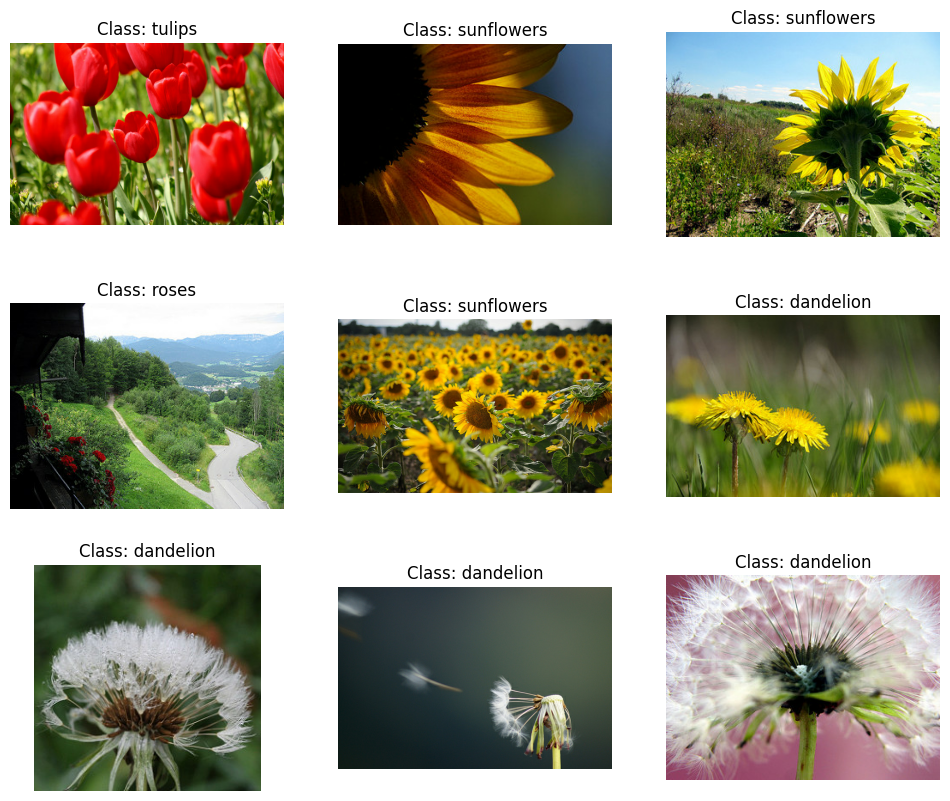

In [75]:
# Observemos las primeras 9 imágenes del conjunto de prueba

plt.figure(figsize=(12, 10))
index = 0
for image, label in test_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

In [76]:
for image, label in test_set_raw.take(9):
    print(image.shape)

(333, 500, 3)
(212, 320, 3)
(240, 320, 3)
(240, 320, 3)
(317, 500, 3)
(212, 320, 3)
(240, 240, 3)
(333, 500, 3)
(240, 320, 3)


### Preprocesamiento del dataset original

Los tres conjuntos de datos contienen imágenes individuales. Necesitamos agruparlas por lotes, pero para ello primero tenemos que asegurarnos de que todas tienen el mismo tamaño, o de lo contrario la agrupación por lotes no funcionará. Para ello podemos utilizar una capa `Resizing`. También debemos llamar a la función `tf.keras.applications.xception.preprocess_input()` para preprocesar las imágenes adecuadamente para el modelo Xception.

In [77]:
tf.keras.backend.clear_session()  # Limpiar la sesión de TensorFlow

batch_size = 32  # Tamaño del lote

# Preprocesar las imágenes
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),  # Redimensionar las imágenes a 224x224 conservando la relación de aspecto
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)  # Aplicar el preprocesamiento específico para el modelo Xception
])

# Conjunto de entrenamiento: aplicar el preprocesamiento, mezclar aleatoriamente, agrupar en lotes y prefetch para optimizar la carga de datos
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)

# Conjunto de validación: aplicar el preprocesamiento y agrupar en lotes
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

# Conjunto de prueba: aplicar el preprocesamiento y agrupar en lotes
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

Veamos de nuevo las 9 primeras imágenes del conjunto de prueba: ahora son todas de 224x224, con valores que van de -1 a 1:

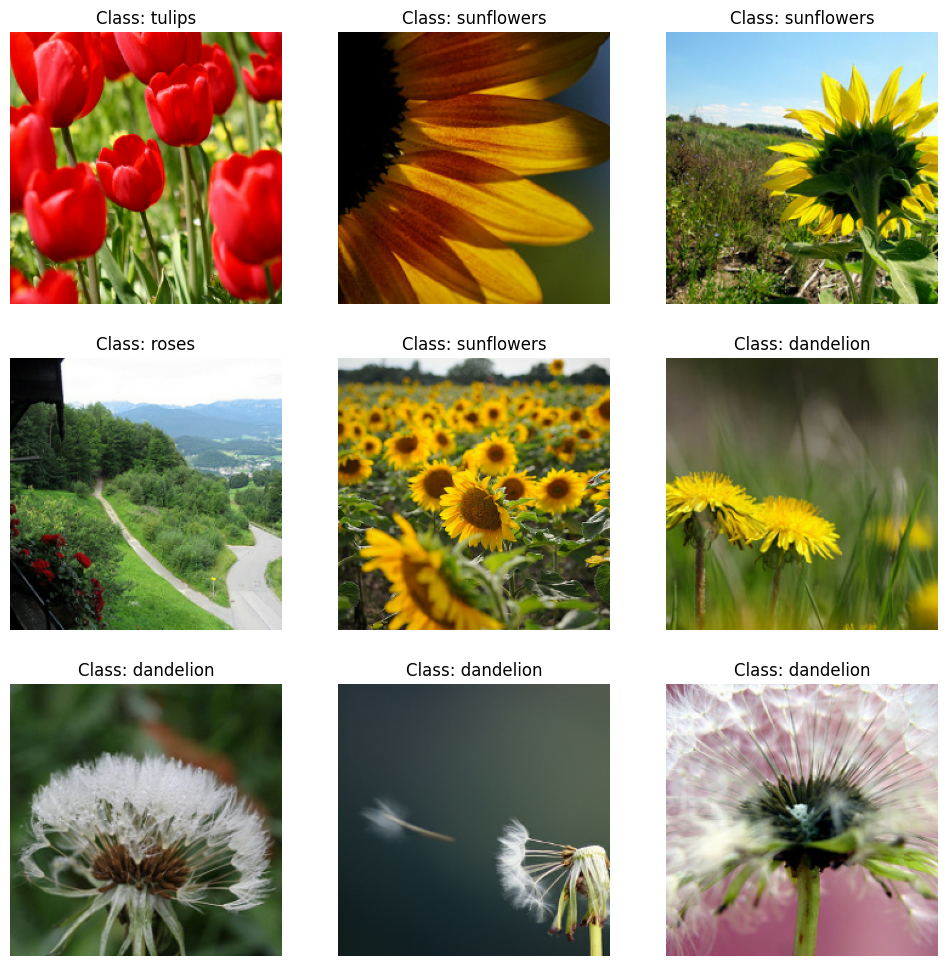

In [78]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # reescala a 0-1 para imshow()
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [79]:
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        print(X_batch[index].shape)

(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


### Aumento de datos (***data augmentation***)

Dado que el conjunto de datos no es muy grande, una ténica común en el procesamiento de imágenes consiste en aumentar el dataset por medio de rotaciones aleatorias a las imágenes del dataset original.


Vamos a crear un modelo de aumento de datos que integraremos en nuestro modelo final. Durante el entrenamiento, volteará aleatoriamente las imágenes en horizontal, las girará un poco y modificará el contraste.

In [80]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

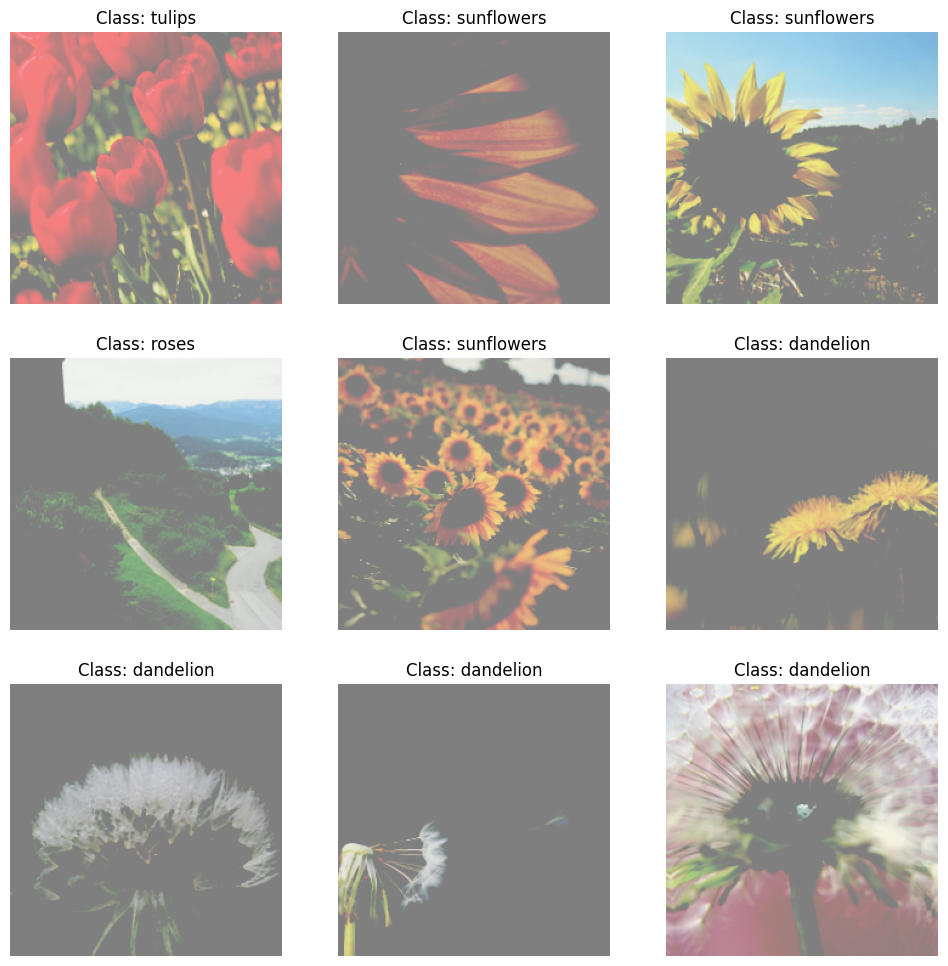

In [81]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # Debemos reescalar las imágenes al rango 0-1 para imshow(), y también
        # recortar el resultado a ese rango, porque el aumento de datos puede
        # hacer que algunos valores se salgan de los límites (por ejemplo, RandomContrast en este caso).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

### Cargar modelo pre-entrenado

Ahora vamos a cargar el modelo preentrenado, sin sus capas superiores (la salida), y a sustituirlas por las nuestras, para la tarea de clasificación de flores

In [87]:
tf.random.set_seed(42)  # Fijar la semilla aleatoria

# Cargar el modelo base Xception preentrenado en ImageNet, sin incluir la capa densa superior
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)

# Aplicar Global Average Pooling (promedio global) sobre la salida del modelo base
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

# Añadir una capa densa final con activación softmax para clasificar 5 clases
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)

# Crear el modelo final especificando las entradas del modelo base y las salidas de la capa densa
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [83]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, None, None, 32)       128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, None, None, 32)       0         ['block1_conv1_bn[0][0]'] 

Vamos a **congelar** las capas (excepto la salida) para que no se vuelvan a entrenar todos los pesos.

In [88]:
for layer in base_model.layers:
    layer.trainable = False

In [85]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, None, None, 32)       128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, None, None, 32)       0         ['block1_conv1_bn[0][0]'] 

### Entrenar el modelo
Por último, podemos compilar el modelo y comenzar el entrenamiento

In [91]:
# Entrenemos el modelo durante pocas épocas, manteniendo fijos los pesos del modelo base:
# OJO Aunque solo sean 3 épocas tomará demasiado tiempo si NO se ejecuta en GPU

optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
86/86 [==============================] - 22s 225ms/step - loss: 0.1171 - accuracy: 0.9615 - val_loss: 0.5484 - val_accuracy: 0.8693
Epoch 2/3
86/86 [==============================] - 16s 181ms/step - loss: 0.0890 - accuracy: 0.9680 - val_loss: 0.5190 - val_accuracy: 0.8802
Epoch 3/3
86/86 [==============================] - 16s 177ms/step - loss: 0.0416 - accuracy: 0.9880 - val_loss: 0.5657 - val_accuracy: 0.8748


### **Descongelar** capas
Es común después de hacer un primer entrenamiento **"descongelar"** algunas de las últimas capas y continuar el entrenamineto, pero **disminuyendo** la tasa de aprendizaje.

In [93]:
# Otra forma de ver la arquitectura de Xception
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_2                33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_6  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_14                 68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_21                
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [94]:
# Habilitar la capacitación de las capas a partir de la posición 56 en adelante del modelo base
# OJO Aunque solo sean 10 épocas tomará demasiado tiempo si NO se ejecuta en GPU

for layer in base_model.layers[56:]:
    layer.trainable = True

# Hay que declarar nuevamente el compilador
# disminuimos la tasa de aprendizaje
# y ejecutamos por 10 épocas
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 [==============================] - 42s 357ms/step - loss: 0.2765 - accuracy: 0.9081 - val_loss: 0.3794 - val_accuracy: 0.8929
Epoch 2/10
86/86 [==============================] - 28s 318ms/step - loss: 0.0594 - accuracy: 0.9818 - val_loss: 0.3691 - val_accuracy: 0.8984
Epoch 3/10
86/86 [==============================] - 31s 355ms/step - loss: 0.0230 - accuracy: 0.9931 - val_loss: 0.3459 - val_accuracy: 0.9056
Epoch 4/10
86/86 [==============================] - 29s 327ms/step - loss: 0.0122 - accuracy: 0.9949 - val_loss: 0.3194 - val_accuracy: 0.9147
Epoch 5/10
86/86 [==============================] - 31s 352ms/step - loss: 0.0067 - accuracy: 0.9978 - val_loss: 0.3357 - val_accuracy: 0.9183
Epoch 6/10
86/86 [==============================] - 30s 339ms/step - loss: 0.0039 - accuracy: 0.9993 - val_loss: 0.3212 - val_accuracy: 0.9238
Epoch 7/10
86/86 [==============================] - 28s 320ms/step - loss: 0.0025 - accuracy: 0.9989 - val_loss: 0.3426 - val_accuracy: 0.9147

In [95]:
model.evaluate(test_set)

12/12 [==============================] - 4s 346ms/step - loss: 0.2615 - accuracy: 0.9346


[0.261549174785614, 0.9346048831939697]